In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sc
import dataframe_image as dfi
from scipy.stats import norm

In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
np.random.seed(42)

In [4]:
sns.set_style("dark")

# Helper functions

In [5]:
def portfolioReturn(weights, annual_returns, annual_cov):
    return sigma_to_sharp(weights, annual_returns, annual_cov)[0]

In [6]:
def portfolioVariance(weights, annual_returns, annual_cov):
    return sigma_to_sharp(weights, annual_returns, annual_cov)[1]

In [7]:
def efficientOpt(annual_returns, annual_cov, returnTarget, constraintSet=(0,1), min_asset=3):
    num_assets = len(annual_returns)
    args = (annual_returns, annual_cov)

    constraints = ({'type':'eq', 'fun': lambda x: portfolioReturn(x, annual_returns, annual_cov) - returnTarget},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
                   # {'type': 'eq', 'fun': lambda x: np.count_nonzero(x==0) - min_asset})
    bound = constraintSet
    bounds = tuple(bound for asset in range(num_assets))
    effOpt = sc.minimize(portfolioVariance, num_assets * [1./num_assets], args=args, method = 'SLSQP', bounds=bounds, constraints=constraints)
    return effOpt

In [8]:
def excel_to_csv (excel_file_name, suffixe, cols_droped=[0,1,3]):
    
    df_excel = pd.read_excel(excel_file_name, parse_dates=False, sheet_name=None, header=3)
    nbr_sheet = len(list(df_excel.values()))
    delete_list = ['CHF',  'EUR', 'GBP', 'Autre', 'USD', 'Autres',
                                  'NON EUR', 'CAD', 'AUD', 'JPY', 'EMCUR',
                                  'Courbe CHF - duration', 'Courbe EUR - duration',
                                  'Courbe USD - duration', 'Courbe Monde - duration',
                                  '% Gouvernementales - courbe CHF', '% Corporate - courbe CHF',
                                  '% Gouvernementales - courbe EUR', '% Corporate - courbe EUR',
                                  '% Gouvernementales - courbe USD', '% Corporate - courbe USD',
                                  '% Gouvernementales - courbe Monde', '% Corporate - courbe Monde',
                                  '% Gouvernementales - Courbe CHF', '% Corporate - Courbe CHF',
                                  '% Gouvernementales - Courbe EUR', '% Corporate - Courbe EUR',
                                  '% Gouvernementales - Courbe USD', '% Corporate - Courbe USD',
                                  '% Gouvernementales - Courbe Monde', '% Corporate - Courbe Monde']
    for i in range(nbr_sheet):
        df = list(df_excel.values())[i]
        sheet_name = list(df_excel.keys())[i]
        if 'No ISIN' not in df.columns:
            continue
        df.dropna(how='all', inplace=True)
        df = df[df['No ISIN'].notna()]
        df = df[-df['No ISIN'].isin(delete_list)]
        df.drop(df.columns[cols_droped], axis=1, inplace=True)
        list_date = list(df.columns)[1:]
        df = df.melt(id_vars='No ISIN', value_vars=list_date, var_name='histo_date', value_name='weight')
        df.dropna(subset=['weight'], inplace=True)
        df = df[df['weight'] != 0]
        df['portfolio'] = suffixe
        df['strategie'] = sheet_name
        df['weight'] = df['weight'].astype('float64')
        df['weight'] = df['weight'].round(4)
        if i==0:
            df_port = df
        if i!=0:
            df_port = pd.concat([df_port, df])
            
    return df_port

In [9]:
def port_filter(portfolio):
    
    portfolio['No ISIN'].replace({
    'Inflation Bond CHF': 'AXGICCH LX Equity',
    'Inflation Bond USD': 'TIPIV Index',
    'Inflation Bond EUR': 'INAVIS31 Index',
    
    'Total Return CHF': 'GSMBIAS LX Equity',
    'Total Return EUR': 'INGLAC Index',
    'Total Return USD': 'INSPFU Index',
    
    'HYBRIDUSD': 'FIDYUHG LX Index',
    'HYBRIDEUR': 'FIDYACE LX Index',
    'HYBRIDCHF': 'NBCHCPA ID Equity',
    
    'UCBIFX02 Index': 'MORSCUA LX Index',
    'UCBIFX28 Index': 'SWBHCHP LX Equity',
    'UCBIFX14 Index': 'MOBILCI LX Index',
    
    'Cat Bond USD': 'LEUPCBU SW Index',
    'Cat Bond CHF': 'SGCIFCH LX equity',
    'Cat Bond EUR': 'LEUPCBE SW Index',

    'LG30TRCH Index': 'H00039CH Index',
    'JPGCHFCP Index': 'CSIFMFH SW Equity',
    'Contrepartie CHF': 'CHF Curncy',
    'Contrepartie EUR': 'EUR Curncy',
    'Contrepartie USD': 'BBDXY Index',
    'aurlnchf curncy': 'AURLNCHF CURNCY',
    'aurlneur curncy': 'AURLNEUR CURNCY',
    'SBWG13U INDEX': 'SBWG13U Index',
    'LF89TRCH index': 'LF89TRCH Index',
    'H30909US INDEX': 'H30909US Index',
    'H30909EU INDEX': 'H30909EU Index',
    'SBWG10U INDEX': 'SBWG10U Index',
    'SBWG10CH INDEX': 'ZKWXBHN SW Equity',
    'SBWGNSUU Index': 'IGLO LN Equity'
    }, inplace=True)

    return portfolio

In [10]:
def get_all_isin(taa_port, curr=None, histo_date=None, strat=None):
    if curr is not None:
        if histo_date is None:
            if strat is None:
                all_isin = taa_port[taa_port['strategie'].str.contains(curr)]
            else:
                all_isin = taa_port[(taa_port['strategie'] == strat) & (taa_port['strategie'].str.contains(curr))]
        else:
            if strat is None:
                all_isin = taa_port[(taa_port['histo_date'] == histo_date) & (taa_port['strategie'].str.contains(curr))]
            else:
                all_isin = taa_port[(taa_port['histo_date'] == histo_date) & (taa_port['strategie'] == strat) & (taa_port['strategie'].str.contains(curr))]
    else:
        if histo_date is None:
            all_isin = taa_port
        else:
            all_isin = taa_port[taa_port['histo_date'] == histo_date]
        
    return pd.DataFrame(all_isin['No ISIN'].unique(), columns=['No ISIN'])

In [11]:
def get_all_strat(taa_port, curr=None):
    if curr is not None:
        all_strat = list(taa_port[taa_port.strategie.str.contains(curr)]['strategie'].unique())
    else:
        all_strat = list(taa_port['strategie'].unique())
        
    return all_strat

In [12]:
def get_weight(taa_port, strategie, histo_date):
    return taa_port[(taa_port['strategie'] == strategie) & (taa_port['histo_date'] == histo_date)][['No ISIN', 'weight']]

In [13]:
def get_all_dates(taa_port, strat=None):
    if strat is not None:
        all_dates = taa_port[taa_port.strategie == strat]['histo_date'].unique()
    else:
        all_dates = taa_port['histo_date'].unique()
    return all_dates

In [14]:
def round_nearest(x, a):
    return round(x / a) * a

In [15]:
def data_filter(data_excel, port, curr, strat=None, date=None):   
    data = data_excel.copy()
    all_isin_port = get_all_isin(port, strat=strat, curr=curr, histo_date=date)
    list_isin = list(all_isin_port['No ISIN'])
    data = data[list_isin]
    num_assets_data = data.shape[1]
    return data

In [16]:
def get_ret_cov(data):  
    daily_returns = data.pct_change()
    annual_returns = ((1 + daily_returns.mean())**252 - 1).values
    daily_cov = daily_returns.cov()
    annual_cov = daily_cov.values * 252
    return annual_returns, annual_cov

In [17]:
def weights_simulation(num_assets_data, num_assets_min_port):
    p = num_assets_min_port / num_assets_data
    weights = np.random.random(num_assets_data)
    weights = np.multiply(weights, np.random.binomial(1, p, size=num_assets_data))
    if np.sum(weights) != 0:
        weights /= np.sum(weights)
    return weights

In [39]:
def sigma_to_sharp (weights, annual_returns, annual_cov):
    
    port_ret = weights @ annual_returns
    port_vol = np.sqrt(weights.T @ annual_cov @ weights )
    if port_vol == 0:
        port_sharp = 0
    else:
        port_sharp = port_ret / port_vol
    
    return port_ret, port_vol, port_sharp

In [19]:
def weights_in_bounds(df_bound, strat='Equilibré CHF'):

    if 'Obligations' in strat:
        condition = (df_bound.at['Obligations', 'weight'] > 0.80) and \
                    (df_bound.at['Obligations', 'weight'] < 0.95) and \
                    (df_bound.at['Liquidités', 'weight'] > 0.02) and \
                    (df_bound.at['Liquidités', 'weight'] < 0.08) and \
                    (df_bound.at['Alternatifs', 'weight'] > 0.02) and \
                    (df_bound.at['Alternatifs', 'weight'] < 0.10)
    if 'Prudent' in strat:
        condition = (df_bound.at['Actions', 'weight'] > 0.05) and \
                    (df_bound.at['Actions', 'weight'] < 0.15) and \
                    (df_bound.at['Obligations', 'weight'] > 0.60) and \
                    (df_bound.at['Obligations', 'weight'] < 0.80) and \
                    (df_bound.at['Liquidités', 'weight'] > 0.02) and \
                    (df_bound.at['Liquidités', 'weight'] < 0.08) and \
                    (df_bound.at['Alternatifs', 'weight'] > 0.06) and \
                    (df_bound.at['Alternatifs', 'weight'] < 0.18)
    if 'Modéré' in strat:
        condition = (df_bound.at['Actions', 'weight'] > 0.20) and \
                    (df_bound.at['Actions', 'weight'] < 0.40) and \
                    (df_bound.at['Obligations', 'weight'] > 0.40) and \
                    (df_bound.at['Obligations', 'weight'] < 0.60) and \
                    (df_bound.at['Liquidités', 'weight'] > 0.02) and \
                    (df_bound.at['Liquidités', 'weight'] < 0.08) and \
                    (df_bound.at['Alternatifs', 'weight'] > 0.06) and \
                    (df_bound.at['Alternatifs', 'weight'] < 0.18)
    if 'Equilibré' in strat:
        condition = (df_bound.at['Actions', 'weight'] > 0.42) and \
                    (df_bound.at['Actions', 'weight'] < 0.56) and \
                    (df_bound.at['Obligations', 'weight'] > 0.23) and \
                    (df_bound.at['Obligations', 'weight'] < 0.47) and \
                    (df_bound.at['Liquidités', 'weight'] > 0.02) and \
                    (df_bound.at['Liquidités', 'weight'] < 0.08) and \
                    (df_bound.at['Alternatifs', 'weight'] > 0.06) and \
                    (df_bound.at['Alternatifs', 'weight'] < 0.18)
    if 'Dynamique' in strat:
        condition = (df_bound.at['Actions', 'weight'] > 0.60) and \
                    (df_bound.at['Actions', 'weight'] < 0.80) and \
                    (df_bound.at['Obligations', 'weight'] > 0.15) and \
                    (df_bound.at['Obligations', 'weight'] < 0.25) and \
                    (df_bound.at['Liquidités', 'weight'] > 0.02) and \
                    (df_bound.at['Liquidités', 'weight'] < 0.08) and \
                    (df_bound.at['Alternatifs', 'weight'] > 0.06) and \
                    (df_bound.at['Alternatifs', 'weight'] < 0.18)
    if 'Engagé' in strat:
        condition = (df_bound.at['Actions', 'weight'] > 0.80) and \
                    (df_bound.at['Actions', 'weight'] < 0.95) and \
                    (df_bound.at['Obligations', 'weight'] > 0.05) and \
                    (df_bound.at['Obligations', 'weight'] < 0.10) and \
                    (df_bound.at['Liquidités', 'weight'] > 0.02) and \
                    (df_bound.at['Liquidités', 'weight'] < 0.08)
    if 'Actions' in strat:
        condition = (df_bound.at['Actions', 'weight'] > 0.90) and \
                    (df_bound.at['Actions', 'weight'] < 0.98) and \
                    (df_bound.at['Liquidités', 'weight'] > 0.02) and \
                    (df_bound.at['Liquidités', 'weight'] < 0.08)
        
    return condition

# Data preparation

In [20]:
port_concur = pd.read_excel('PP_data/saa_concurrents.xlsx', parse_dates=False, sheet_name='Feuil1', header=3)
port_concur.drop(port_concur.columns[[0,1]], axis=1, inplace=True)
port_concur = port_concur.rename(columns={'Ticker': 'No ISIN'})
port_concur = port_concur[port_concur['No ISIN'].notna()]
port_concur.drop(port_concur.columns[26:], axis=1, inplace=True)
list_concurrents = list(port_concur.columns)[1:]
port_concur = port_concur.melt(id_vars='No ISIN', value_vars=list_concurrents, var_name='concurrent', value_name='weight')
port_concur.dropna(subset=['weight'], inplace=True)
port_concur = port_concur[port_concur['weight'] != 0]

In [52]:
all_concurrents = list(set(list(port_concur['concurrent'].unique())) - set(['Modéré CHF', 'Equilibré CHF', 'Dynamique CHF', 'Engagé CHF', 'Actions CHF']))
all_concurrents

['SWC LPP25',
 'BCV Modéré',
 'BCV Actions',
 'SWC Select 2021',
 'SWC LPP40',
 'SWC Ambition 2021',
 'CS Equilibré',
 'BCVs Pension 35',
 'UBS Actions 2021',
 'UBS Equilibré 2021',
 'SWC Balance 2021',
 'BCVs Opportunity',
 'CS Modéré',
 'BCVs Conservative',
 'UBS Dynamique 2021',
 'SWC Focus 2021',
 'BCV Equilibré',
 'BCV Dynamique',
 'UBS Modéré 2021',
 'CS Dynamique']

In [21]:
indice_excel = pd.read_excel('pp_data/fund_data.xlsx', sheet_name='indice', header=0, parse_dates=False)
indice_excel = indice_excel[['Valeur', 'PP_L1', 'PP_CHF_L2']].rename(columns={'Valeur': 'No ISIN'})
classe_data = port_filter(indice_excel)

In [22]:
saa_port_excel = excel_to_csv('PP_data/saa.xlsx', 'PP', [1])
saa_port_excel.drop(columns='portfolio', inplace=True)
saa_port_excel = port_filter(saa_port_excel)

In [23]:
taa_port_excel = excel_to_csv('PP_data/taa.xlsx', 'PP')
taa_port_excel.drop(columns='portfolio', inplace=True)
taa_port_excel = port_filter(taa_port_excel)

In [24]:
taa_port = taa_port_excel.copy()
saa_port = saa_port_excel.copy()

In [25]:
date = '2020-12-31'
curr = 'CHF'
port = saa_port

In [26]:
data_excel = pd.read_excel('PP_data/indices_tickers_pp.xlsx', sheet_name='close_price', skiprows=[0,1,2,4,5,6,7])
data_excel.rename(columns = { data_excel.columns[0]: "Dates" }, inplace = True)
data_excel['Dates'] = pd.to_datetime(data_excel['Dates'], yearfirst=True, format="%d/%m/%Y")
data_excel = data_excel.fillna(method='ffill')
data_excel.index = data_excel['Dates']
data_excel = data_excel.drop(columns=['Dates'])
data_excel_futur = data_excel.loc[date:]
data_excel_histo = data_excel.loc[:date]

In [27]:
all_strategies = get_all_strat(port, curr)
all_isin_port = get_all_isin(port, curr=curr, histo_date=date)

# Random portfolio simulation

In [41]:
num_portfolios = 1000
alpha = 0.05

In [42]:
data = data_filter(data_excel_histo, port, curr, date=date)
list_isin = list(data.columns)
num_assets_port = []
for strat in all_strategies:
    all_dates = get_all_dates(port, strat)
    for temp_date in all_dates:
        num_assets_port.append(len(get_all_isin(port, strat, temp_date)))
num_assets_min_port = np.array(num_assets_port).min()

/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


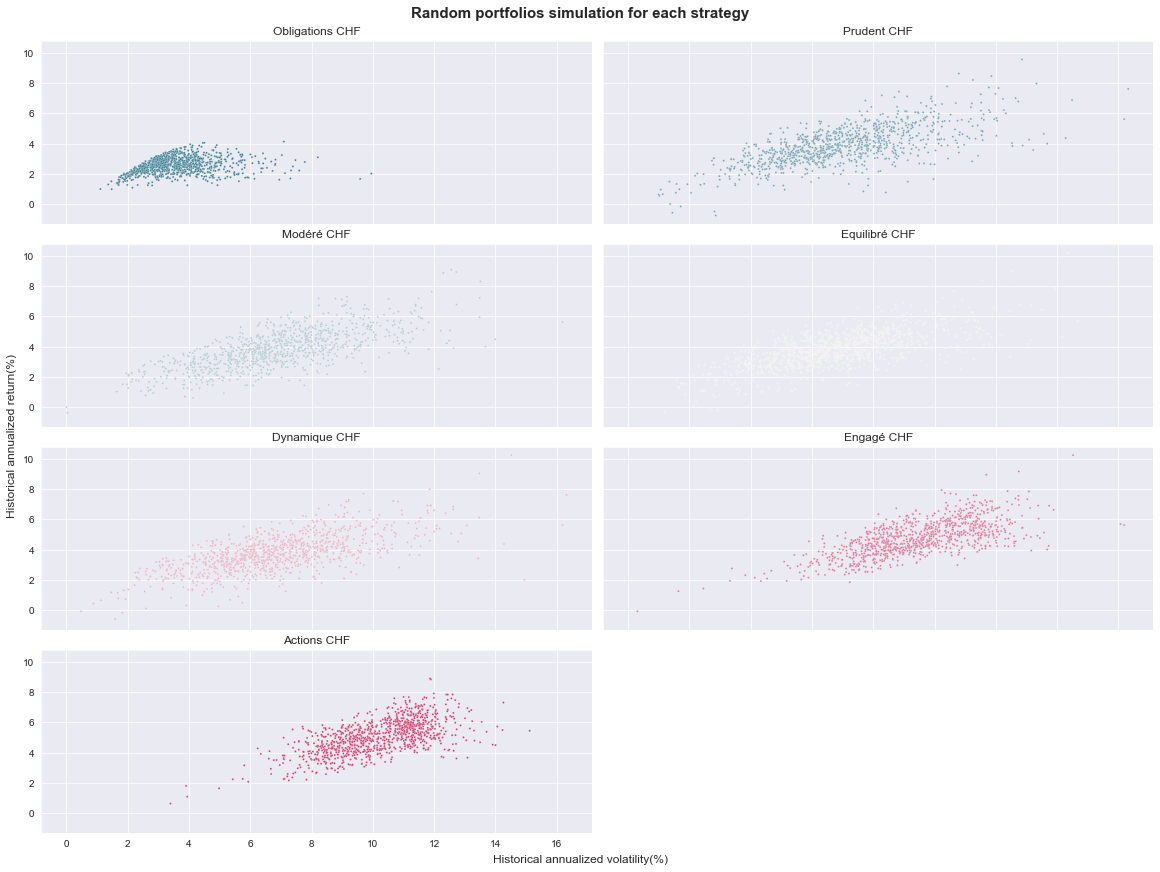

In [43]:
df = pd.DataFrame(columns=['returns', 'volatility', 'var', 'sharpe_ratio', 'strategie'])
df_weight = pd.DataFrame(columns=list_isin)
    
fig, axs = plt.subplots(4,2, figsize=(16,12), sharex=True, sharey=True, constrained_layout=True)
axs = axs.ravel()
pal = sns.diverging_palette(220, 0, n=len(all_strategies), l=50)
                         
for i, strat in enumerate(all_strategies):
    
    weight_list = []
    
    port_returns = []
    port_volatility = []
    port_var = []
    sharpe_ratio = []
    
    data = data_filter(data_excel_histo, port=port, strat=strat, curr=curr, date=date)
    list_isin_strat = list(data.columns)
    num_assets_data = data.shape[1]
    annual_returns, annual_cov = get_ret_cov(data)
    
    for single_port in range(num_portfolios):
            
        weights = weights_simulation(num_assets_data, num_assets_min_port)
        df_weight_classe = pd.DataFrame(data=zip(list_isin_strat, weights), columns=['No ISIN', 'weight']).merge(classe_data, on='No ISIN', how='left')
        df_bound = df_weight_classe.groupby('PP_L1').sum()
        
        while weights_in_bounds(df_bound, strat):
            weights = weights_simulation(num_assets_data, num_assets_min_port)
            df_weight_classe = pd.DataFrame(data=zip(list_isin_strat, weights), columns=['No ISIN', 'weight']).merge(classe_data, on='No ISIN', how='left')
            df_bound = df_weight_classe.groupby('PP_L1').sum()
                
        
        returns, volatility, sharpe = sigma_to_sharp(weights, annual_returns, annual_cov)
        var = 1 - norm.ppf(alpha, (returns + 1), volatility)

        sharpe_ratio.append(sharpe)
        port_returns.append(returns)
        port_volatility.append(volatility)
        port_var.append(var)
        weight_list.append(weights)

    df_temp = pd.DataFrame(data={'returns': port_returns,
                                 'volatility': port_volatility,
                                 'var': var,
                                 'sharpe_ratio': sharpe_ratio,
                                 'strategie': strat})
    
    df_temp.returns *= 100
    df_temp.volatility *= 100

    df_temp = df_temp.loc[round_nearest(df_temp[['returns', 'volatility']],0.02).drop_duplicates(subset=('returns', 'volatility')).index]
    df = df.append(df_temp)
    
    df_weight_temp = pd.DataFrame(data=weight_list, columns=list_isin_strat)
    df_weight_temp = df_weight_temp.loc[df_temp.index]
    df_weight = pd.concat([df_weight, df_weight_temp])
                         
    axs[i].set_title(strat)
    axs[i] = sns.scatterplot(ax=axs[i], data=df_temp, x='volatility', y='returns', hue='strategie', palette=list((pal[i],)), s=4, legend=False)
    axs[i].grid()
    axs[i].set(xlabel=None)
    axs[i].set(ylabel=None)


df = df.reset_index(drop=True) 
df = df.loc[round_nearest(df[['returns', 'volatility']],0.02).drop_duplicates(subset=('returns', 'volatility')).index]

df_weight = df_weight.reset_index(drop=True)
df_weight = df_weight.loc[df.index]

fig.delaxes(axs[7])
fig.suptitle('Random portfolios simulation for each strategy', fontsize=15, fontweight='bold')
fig.supxlabel('Historical annualized volatility(%)', fontsize=12)
fig.supylabel('Historical annualized return(%)', fontsize=12)
plt.savefig('pp_output/individual_simulation.png')
plt.show()

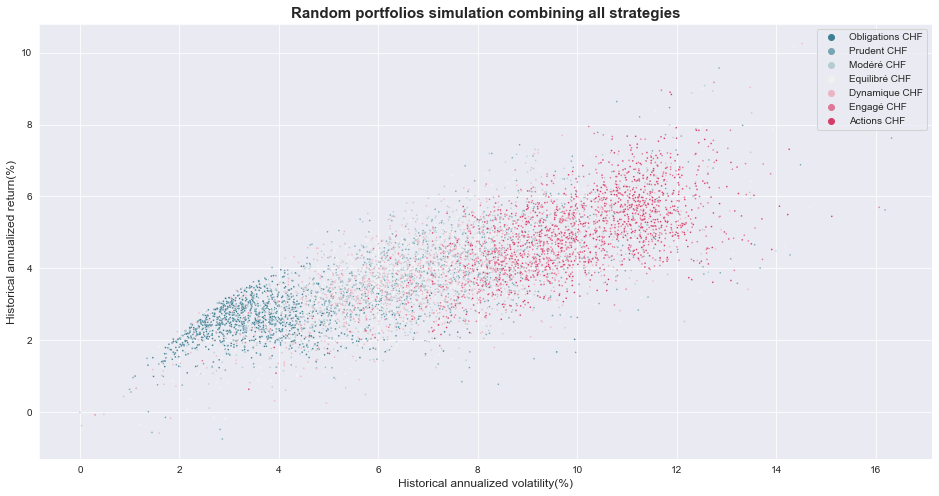

In [44]:
pal = sns.diverging_palette(220, 0, n=len(all_strategies), l=50)
fig = plt.figure(figsize=(16,8))
ax = sns.scatterplot(data=df, x='volatility', y='returns', hue='strategie', palette=pal, s=3, legend=True)
ax.legend().set_title(None)
plt.title('Random portfolios simulation combining all strategies', fontsize=15, fontweight='bold')
plt.xlabel('Historical annualized volatility(%)', fontsize=12)
plt.ylabel('Historical annualized return(%)', fontsize=12)
plt.grid()
plt.savefig('pp_output/global_simulation.png')
plt.show()

# Comparison with strategies

In [32]:
data = data_filter(data_excel_histo, port, curr=curr, date=date)
num_assets_data = data.shape[1]
annual_returns, annual_cov = get_ret_cov(data)

list_isin = list(get_all_isin(port, curr=curr, histo_date=date)['No ISIN'])
df_port = pd.DataFrame(columns=['returns', 'volatility', 'var', 'sharpe_ratio', 'strategie'])

for strat in all_strategies:
    portfolio = get_weight(port, strat, date).reset_index(drop=True)
    portfolio = pd.merge(portfolio, all_isin_port, how='outer', on='No ISIN').fillna(0).drop_duplicates()
    portfolio = portfolio.set_index('No ISIN').reindex(list_isin)
    weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
    port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, annual_returns, annual_cov)
    port_var = 1 - norm.ppf(alpha, (port_ret + 1), port_vol)
    df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol, 'var': port_var,
                            'sharpe_ratio': port_sharpe, 'strategie': strat}, index=[0])
    df_port = df_port.append(df_temp)
    
df_port.returns *= 100
df_port.volatility *= 100

In [59]:
all_isin_port_concur = pd.DataFrame(port_concur['No ISIN'].unique(), columns=['No ISIN'])
list_isin_concur = list(all_isin_port_concur['No ISIN'])
df_port_concur = pd.DataFrame(columns=['returns', 'volatility', 'var', 'sharpe_ratio', 'concurrent'])

data = data_excel_histo.copy()
data = data[list_isin_concur]
annual_returns, annual_cov = get_ret_cov(data)

for concur in all_concurrents:
    portfolio = port_concur[port_concur.concurrent == concur][['No ISIN', 'weight']]
    portfolio = pd.merge(portfolio, all_isin_port_concur, how='outer', on='No ISIN').fillna(0).drop_duplicates()
    portfolio = portfolio.set_index('No ISIN').reindex(list_isin_concur)
    weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
    port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, annual_returns, annual_cov)
    port_var = 1 - norm.ppf(alpha, (port_ret + 1), port_vol)
    df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol, 'var': port_var,
                            'sharpe_ratio': port_sharpe, 'strategie': concur}, index=[0])
    df_port_concur = df_port_concur.append(df_temp)
    
df_port_concur.returns *= 100
df_port_concur.volatility *= 100

KeyError: "['SBR14T Index', 'JHCC1R10 Index', 'FTS7EURB Index', 'LF93TR Index', 'JPGCHFCP Index', 'ST115T Index', 'UCBIFX28 Index', 'M4CXCSAQ Index', 'LECPTRCH Index', 'SF110T Index', 'NDUEAWXZ Index', 'SBWGNSUU Index', 'SBWGSZC Index', 'SBSZ57L Index', 'H05394CH Index', 'M1CXAMPE Index', 'LG30TRCH Index', 'BC31TRCH Index', 'M0CAHCHFIndex', 'SBSZ35L Index', 'AURLNCHF Curncy', 'LEATTREU Index', 'M7CXSSD Index'] not in index"

In [60]:
liste_tick = ['SBR14T Index', 'JHCC1R10 Index', 'FTS7EURB Index', 'LF93TR Index', 'JPGCHFCP Index', 'ST115T Index', 'UCBIFX28 Index', 'M4CXCSAQ Index', 'LECPTRCH Index', 'SF110T Index', 'NDUEAWXZ Index', 'SBWGNSUU Index', 'SBWGSZC Index', 'SBSZ57L Index', 'H05394CH Index', 'M1CXAMPE Index', 'LG30TRCH Index', 'BC31TRCH Index', 'M0CAHCHFIndex', 'SBSZ35L Index', 'AURLNCHF Curncy', 'LEATTREU Index', 'M7CXSSD Index']

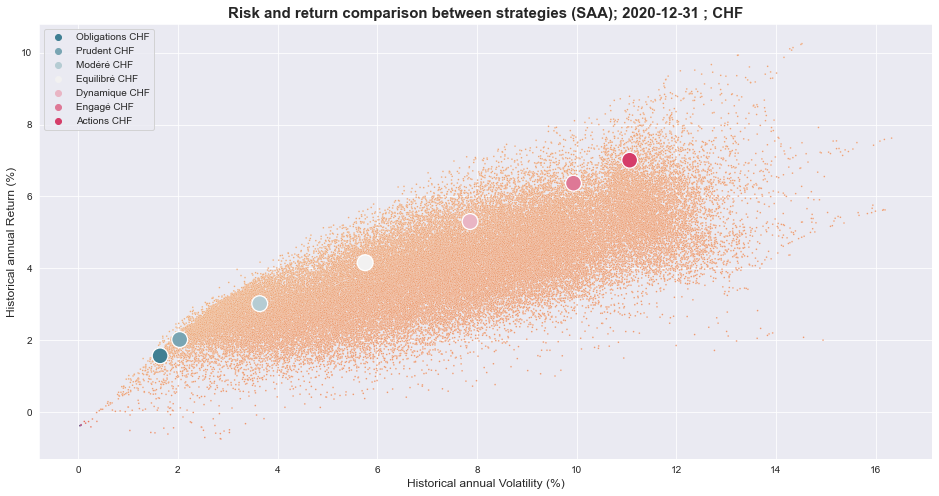

In [33]:
fig = plt.figure(figsize=(16,8))
ax1 = sns.scatterplot(data=df, x='volatility', y='returns', hue='sharpe_ratio', palette=sns.color_palette("flare_r", as_cmap=True), s=3, legend=False)
ax2 = sns.scatterplot(data=df_port, x='volatility', y='returns', hue='strategie', palette=sns.diverging_palette(220, 0, n=len(df_port)), s=250)
ax2.legend().set_title(None)
plt.title('Risk and return comparison between strategies (SAA); ' + date + ' ; ' + curr, fontweight='bold', fontsize=15)
plt.xlabel('Historical annual Volatility (%)', fontsize=12)
plt.ylabel('Historical annual Return (%)', fontsize=12)
plt.grid()
plt.savefig('pp_output/strategies_comparison_sharpe.png')
plt.show()

In [34]:
delta = 0.05
df_optimal_weight = pd.DataFrame(columns=all_strategies)
list_isin = list(get_all_isin(port, curr=curr, histo_date=date)['No ISIN'])
for strat in all_strategies:
    vol_min = df_port[df_port.strategie == strat].volatility.values[0] - delta
    vol_max = df_port[df_port.strategie == strat].volatility.values[0] + delta
    df_strat = df[(df.volatility > vol_min) & (df.volatility < vol_max) & (df.strategie==strat)]
    portfolio = df_weight.loc[df_strat.returns.idxmax()].reindex(list_isin)
    df_optimal_weight[strat] = portfolio

In [35]:
data = data_filter(data_excel_histo, port, curr=curr, date=date)
num_assets_data = data.shape[1]
annual_returns, annual_cov = get_ret_cov(data)

list_isin = list(get_all_isin(port, curr=curr, histo_date=date)['No ISIN'])
df_optimal_port = pd.DataFrame(columns=['returns', 'volatility', 'var', 'sharpe_ratio', 'strategie'])

for strat in all_strategies:
    portfolio = df_optimal_weight[strat].reset_index(drop=False).rename(columns={'index': 'No ISIN', strat:'weight'})
    portfolio = pd.merge(portfolio, all_isin_port, how='outer', on='No ISIN').fillna(0).drop_duplicates()
    portfolio = portfolio.set_index('No ISIN').reindex(list_isin)
    weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
    port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, annual_returns, annual_cov)
    port_var = 1 - norm.ppf(alpha, (port_ret + 1), port_vol)
    df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol, 'var': port_var,
                            'sharpe_ratio': port_sharpe, 'strategie': strat}, index=[0])
    df_optimal_port = df_optimal_port.append(df_temp)
    
df_optimal_port.returns *= 100
df_optimal_port.volatility *= 100

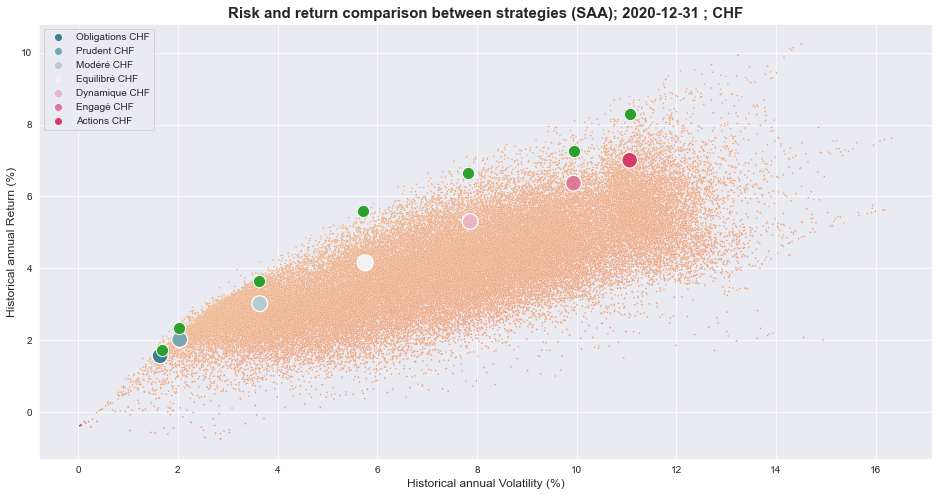

In [36]:
fig = plt.figure(figsize=(16,8))
ax1 = sns.scatterplot(data=df, x='volatility', y='returns', hue='sharpe_ratio', palette=sns.color_palette("flare_r", as_cmap=True), s=3, legend=False)
ax2 = sns.scatterplot(data=df_port, x='volatility', y='returns', hue='strategie', palette=sns.diverging_palette(220, 0, n=len(df_port)), s=250)
ax3 = sns.scatterplot(data=df_optimal_port, x='volatility', y='returns', s=150, legend=False)
ax2.legend().set_title(None)
plt.title('Risk and return comparison between strategies (SAA); ' + date + ' ; ' + curr, fontweight='bold', fontsize=15)
plt.xlabel('Historical annual Volatility (%)', fontsize=12)
plt.ylabel('Historical annual Return (%)', fontsize=12)
plt.grid()
plt.savefig('pp_output/strategies_comparison_sharpe.png')
plt.show()

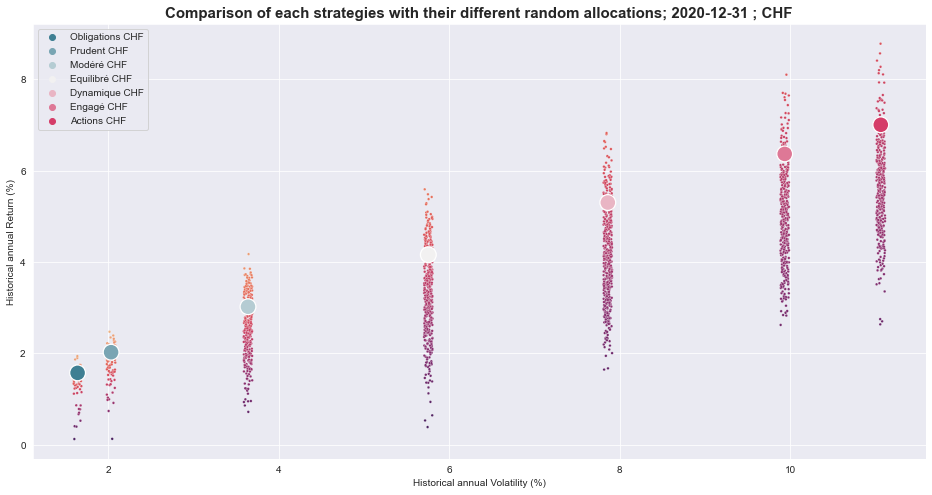

,Obligations CHF,Prudent CHF,Modéré CHF,Equilibré CHF,Dynamique CHF,Engagé CHF,Actions CHF
Top %,28.3,26.74,30.37,21.54,15.25,11.95,9.26
Return delta with best candidate (%),0.37,0.45,1.15,1.43,1.52,1.74,1.78


In [37]:
df_strat_concat = pd.DataFrame()
df_port_strat = pd.DataFrame()
df_top_percent = pd.DataFrame(columns=all_strategies)

pal = sns.diverging_palette(220, 0, n=len(df_port))
delta = 0.05
for strat in all_strategies:
    vol_min = df_port[df_port.strategie == strat].volatility.values[0] - delta
    vol_max = df_port[df_port.strategie == strat].volatility.values[0] + delta
    df_strat = df[(df.volatility > vol_min) & (df.volatility < vol_max)]
    df_strat = df_strat.loc[round_nearest(df_strat['returns'],0.005).drop_duplicates().index]
    df_strat_concat = df_strat_concat.append(df_strat)
    df_port_strat = df_port[df_port.strategie==strat]
    df_strat_all = df_strat.returns.append(df_port_strat.returns).sort_values().reset_index(drop=True)
    strat_top = df_strat_all.index[df_strat_all == df_port_strat.returns.values[0]].to_list()[0]
    strat_top_percent = round(100 * (1 - strat_top / len(df_strat)),2)
    strat_top_dist = round(df_strat.max().values[0] - df_port_strat.returns.values[0],2)
    df_top_percent.at['Top %', strat] = strat_top_percent
    df_top_percent.at['Return delta with best candidate (%)', strat] = strat_top_dist


fig = plt.figure(figsize=(16,8))
ax1 = sns.scatterplot(data=df_strat_concat, x='volatility', y='returns', hue='sharpe_ratio', palette=sns.color_palette("flare_r", as_cmap=True), s=7, legend=False)
ax2 = sns.scatterplot(data=df_port, x='volatility', y='returns', hue='strategie', palette=pal, s=250)
ax2.legend().set_title(None)
plt.title('Comparison of each strategies with their different random allocations; ' + date + ' ; ' + curr, fontsize=15, fontweight='bold')
plt.xlabel('Historical annual Volatility (%)')
plt.ylabel('Historical annual Return (%)')
plt.grid()
plt.savefig('pp_output/strategies_comparison_ranking.png')
plt.show()

display(df_top_percent)
dfi.export(df_top_percent, 'pp_output/ranking_table.png')

# Comparison between historical and futur risk and performance

In [38]:
weight_list = []
df_futur = pd.DataFrame(columns=['returns', 'volatility', 'var', 'sharpe_ratio', 'strategie'])

for i, strat in enumerate(all_strategies):
    
    port_returns = []
    port_volatility = []
    port_var = []
    sharpe_ratio = []
    
    data = data_filter(data_excel_futur, port=port, strat=strat, curr=curr, date=date)
    num_assets_data = data.shape[1]
    annual_returns, annual_cov = get_ret_cov(data)
    
    for single_port in range(num_portfolios):
            
        weights = weights_simulation(num_assets_data, num_assets_min_port)
        df_weight_classe = pd.DataFrame(data=zip(list_isin_strat, weights), columns=['No ISIN', 'weight']).merge(classe_data, on='No ISIN', how='left')
        df_bound = df_weight_classe.groupby('PP_L1').sum()
        
        while weights_in_bounds(df_bound, strat):
            weights = weights_simulation(num_assets_data, num_assets_min_port)
            df_weight_classe = pd.DataFrame(data=zip(list_isin_strat, weights), columns=['No ISIN', 'weight']).merge(classe_data, on='No ISIN', how='left')
            df_bound = df_weight_classe.groupby('PP_L1').sum()
        
        returns, volatility, sharpe = sigma_to_sharp(weights, annual_returns, annual_cov)
        var = 1 - norm.ppf(alpha, (returns + 1), volatility)

        sharpe_ratio.append(sharpe)
        port_returns.append(returns)
        port_volatility.append(volatility)
        port_var.append(var)
        weight_list.append(weights)
    
    df_temp = pd.DataFrame(data={'returns': port_returns,
                                 'volatility': port_volatility,
                                 'var': port_var,
                                 'sharpe_ratio': sharpe_ratio,
                                 'strategie': strat})
    
    df_temp.returns *= 100
    df_temp.volatility *= 100
    df_temp = df_temp.loc[round_nearest(df_temp[['returns', 'volatility']],0.02).drop_duplicates(subset=('returns', 'volatility')).index]
    
    df_futur = df_futur.append(df_temp)

df_futur = df_futur.reset_index(drop=True) 
df_futur = df_futur.loc[round_nearest(df[['returns', 'volatility']],0.02).drop_duplicates(subset=('returns', 'volatility')).index]

data = data_filter(data_excel_futur, port=port, curr=curr, date=date)
num_assets_data = data.shape[1]
annual_returns, annual_cov = get_ret_cov(data)

df_port_futur = pd.DataFrame(columns=['returns', 'volatility', 'var', 'sharpe_ratio', 'strategie'])
date_port = date
for strat in all_strategies:
    portfolio = get_weight(port, strat, date_port).reset_index(drop=True)
    portfolio = pd.merge(portfolio, all_isin_port, how='outer', on='No ISIN').fillna(0).drop_duplicates()
    portfolio = portfolio.set_index('No ISIN').reindex(list(all_isin_port['No ISIN']))
    weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
    port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, annual_returns, annual_cov)
    port_var = 1 - norm.ppf(alpha, (port_ret + 1), port_vol)
    df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol, 'var': port_var,
                            'sharpe_ratio': port_sharpe, 'strategie': strat}, index=[0])
    df_port_futur = df_port_futur.append(df_temp)
    
df_port_futur.returns = df_port_futur.returns * 100
df_port_futur.volatility = df_port_futur.volatility * 100

KeyError: 'Obligations'

In [ ]:
data = data_filter(data_excel_futur, port, curr=curr, date=date)
num_assets_data = data.shape[1]
annual_returns, annual_cov = get_ret_cov(data)

list_isin = list(get_all_isin(port, curr=curr, histo_date=date)['No ISIN'])
df_optimal_port_futur = pd.DataFrame(columns=['returns', 'volatility', 'var', 'sharpe_ratio', 'strategie'])

for strat in all_strategies:
    portfolio = df_optimal_weight[strat].reset_index(drop=False).rename(columns={'index': 'No ISIN', strat:'weight'})
    portfolio = pd.merge(portfolio, all_isin_port, how='outer', on='No ISIN').fillna(0).drop_duplicates()
    portfolio = portfolio.set_index('No ISIN').reindex(list_isin)
    weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
    port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, annual_returns, annual_cov)
    port_var = 1 - norm.ppf(alpha, (port_ret + 1), port_vol)
    df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol, 'var': port_var,
                            'sharpe_ratio': port_sharpe, 'strategie': strat}, index=[0])
    df_optimal_port_futur = df_optimal_port_futur.append(df_temp)
    
df_optimal_port_futur.returns *= 100
df_optimal_port_futur.volatility *= 100

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(16,12), sharex=True, sharey=True, constrained_layout=True)
axs = axs.ravel()

pal = sns.diverging_palette(220, 0, n=len(all_strategies), l=50)
# pal_opt = sns.color_palette("light:#5A9")[1]

sns.scatterplot(ax=axs[0], data=df, x='volatility', y='returns', hue='sharpe_ratio', palette=sns.color_palette("flare_r", as_cmap=True), s=3, legend=False)
sns.scatterplot(ax=axs[0], data=df_port, x='volatility', y='returns', hue='strategie', palette=sns.diverging_palette(220, 0, n=len(df_port)), s=250)
sns.scatterplot(ax=axs[0], data=df_optimal_port, x='volatility', y='returns', s=150, legend=False)

axs[0].grid()
axs[0].set_title('Historical', fontsize=12)
axs[0].set(xlabel=None)
axs[0].set(ylabel=None)
axs[0].legend().set_title(None)


sns.scatterplot(ax=axs[1], data=df_futur, x='volatility', y='returns', hue='sharpe_ratio', palette=sns.color_palette("flare_r", as_cmap=True), s=3, legend=False)
sns.scatterplot(ax=axs[1], data=df_port_futur, x='volatility', y='returns', hue='strategie', palette=sns.diverging_palette(220, 0, n=len(df_port)), s=250)
sns.scatterplot(ax=axs[1], data=df_optimal_port_futur, x='volatility', y='returns', s=150, legend=False)
axs[1].grid()
axs[1].set_title('Futur', fontsize=12)
axs[1].set(xlabel=None)
axs[1].set(ylabel=None)
axs[1].legend().set_title(None)

fig.suptitle('Efficient frontier comparison between historical and futur price data', fontsize=15, fontweight='bold')
fig.supxlabel('Annualized volatility(%)', fontsize=12)
fig.supylabel('Annualized return(%)', fontsize=12)
plt.savefig('pp_output/historical_futur_comparison.png')
plt.show()

In [ ]:
fig = plt.figure(figsize=(16,8))
ax1 = sns.scatterplot(data=df_futur, x='volatility', y='returns', hue='sharpe_ratio', palette=sns.color_palette("flare_r", as_cmap=True), s=3, legend=False)
ax2 = sns.scatterplot(data=df_port_futur, x='volatility', y='returns', hue='strategie', palette=sns.diverging_palette(220, 0, n=len(df_port)), s=250)
ax2.legend().set_title(None)
plt.title('Risk and return comparison between strategies (SAA); ' + date + ' ; ' + curr, fontweight='bold', fontsize=15)
plt.xlabel('Annual Volatility (%)', fontsize=12)
plt.ylabel('Annual Return (%)', fontsize=12)
plt.grid()
plt.savefig('pp_output/strategies_comparison_sharpe_futur.png')
plt.show()

In [ ]:
palette = sns.diverging_palette(220, 0, n=len(df_port_futur))
df_strat_concat = pd.DataFrame()
df_port_futur_strat = pd.DataFrame()
df_top_percent = pd.DataFrame(columns=all_strategies)

for pal, strat in zip(palette, all_strategies):
    delta = 0.1
    vol_min = df_port_futur[df_port_futur.strategie == strat].volatility.values[0] - delta
    vol_max = df_port_futur[df_port_futur.strategie == strat].volatility.values[0] + delta
    df_strat = df_futur[(df_futur.volatility > vol_min) & (df_futur.volatility < vol_max)]
    df_strat = df_strat.loc[round_nearest(df_strat['returns'],0.01).drop_duplicates().index]
    df_strat_concat = df_strat_concat.append(df_strat)
    df_port_futur_strat = df_port_futur[df_port_futur.strategie==strat]
    
    df_strat_all = df_strat.returns.append(df_port_futur_strat.returns).sort_values().reset_index(drop=True)
    strat_top = df_strat_all.index[df_strat_all == df_port_futur_strat.returns.values[0]].to_list()[0]
    strat_top_percent = round(100 * (1 - strat_top / len(df_strat)),2)
    strat_top_dist = round(df_strat.max().values[0] - df_port_futur_strat.returns.values[0],2)
    
    df_top_percent.at['Top %', strat] = strat_top_percent
    df_top_percent.at['Return delta with best candidate (%)', strat] = strat_top_dist

display(df_top_percent)

fig = plt.figure(figsize=(16,8))
ax1 = sns.scatterplot(data=df_strat_concat, x='volatility', y='returns', hue='sharpe_ratio', palette=sns.color_palette("flare_r", as_cmap=True), s=7, legend=False)
ax2 = sns.scatterplot(data=df_port_futur, x='volatility', y='returns', hue='strategie', palette=palette, s=250)
ax2.legend().set_title(None)
plt.title('Comparison of each strategies with their different random allocations; ' + date + ' ; ' + curr)
plt.xlabel('Annual Volatility (%)')
plt.ylabel('Annual Return (%)')
plt.grid()
plt.savefig('pp_output/strategies_comparison_ranking_futur.png')
plt.show()

dfi.export(df_top_percent, 'pp_output/ranking_table_futur.png')

# Optimal portfolio frontier

data = data_excel.copy()
all_isin_port = get_all_isin(port, curr=curr)
list_isin = list(all_isin_port['No ISIN'])
data = data[list_isin]
num_assets_data = data.shape[1]

daily_returns = data.pct_change()
annual_returns = ((1 + daily_returns.mean())**252 - 1).values
daily_cov = daily_returns.cov()
annual_cov = daily_cov.values * 252

Sigmap = []
Mup_min = df.returns.iloc[df.volatility.argmin()] / 100
Mup_max = df.returns.max() / 100
Mup = np.linspace(0, Mup_max, 100)
for target in tqdm(Mup):
    Sigmap.append(efficientOpt(annual_returns, annual_cov, target)['fun'])

plt.style.use('seaborn-dark')
fig = plt.figure(figsize=(16,8))
ax1 = sns.scatterplot(data=df, x='volatility', y='returns', hue='sharpe_ratio', palette=sns.color_palette("flare_r", as_cmap=True), s=3, legend=False)
ax2 = sns.lineplot(x=np.array(Sigmap)*100, y=np.array(Mup)*100, sort=False, lw=1, palette="flare")
ax3 = sns.scatterplot(data=df_port, x='volatility', y='returns', hue='strategie', palette=sns.diverging_palette(220, 0, n=len(df_port)), s=250)
plt.title('Efficient Frontier')
plt.xlabel('Annual Volatility (%)')
plt.ylabel('Annual Return (%)')
plt.grid()
plt.show()

# DRAFT

In [ ]:
# Efficient Frontier
Sigmap = []
Mup_min = df.returns.min() / 100
Mup_max = df.returns.max() / 100
Mup = np.linspace(0, Mup_max, 10)
for target in tqdm(Mup):
    Sigmap.append(efficientOpt(annual_returns, annual_cov, target)['x'])

In [ ]:
# df_test = pd.DataFrame(columns=Mup, data=np.array(Sigmap).T)
# (df_test*100).round(2)

In [ ]:
np.count_nonzero(np.array(Sigmap)==0, axis=1)

In [ ]:
num_asset_port = []
for strat in all_strategies:
    portfolio = get_weight(taa_port, strat, date_port)
    num_asset_port.append(len(portfolio))
np.array(num_asset_port)